### Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer

# spacy for lemmatization
#import spacy

import re

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data and build LDA model

In [2]:
raw_data = pd.read_csv('Data2018.csv')
raw_data.head()

,reviews.rating,reviews.text,reviews_year
0,4.0,Hotel is in the perfect spot at the perfect pr...,2018
1,4.6,Bad: Timing seemed to be off. Had to wait a ve...,2018
2,4.8,Good: I loved the quirkiness and style of the ...,2018
3,5.0,Bad: This is really not a reflection on the ho...,2018
4,5.0,"Good: Perfection - beautiful rooms, comfortabl...",2018


In [3]:
# Negative reviews when rating is below 3
data_neg = raw_data[raw_data['reviews.rating'].apply(lambda x: x < 3)].reset_index(drop=True)
data_neg.head()

,reviews.rating,reviews.text,reviews_year
0,2.9,Bad: Just want to say paying 330 for one night...,2018
1,2.5,"Bad: The place was falling apart, the tub was ...",2018
2,2.9,Bad: No business center..wifi wasnt free..it a...,2018
3,2.5,"Bad: Old outdated rooms, even though its a cla...",2018
4,2.7,Bad: Size of room. Good: Leaving,2018


In [4]:
# Text preprocessing steps - remove numbers, capital letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r'\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

data_neg['reviews.text'] = data_neg['reviews.text'].map(alphanumeric).map(punc_lower)

data_neg.head()

,reviews.rating,reviews.text,reviews_year
0,2.9,bad just want to say paying for one night wou...,2018
1,2.5,bad the place was falling apart the tub was cr...,2018
2,2.9,bad no business centerwifi wasnt freeit asked ...,2018
3,2.5,bad old outdated rooms even though its a class...,2018
4,2.7,bad size of room good leaving,2018


In [5]:
neg_reviews = data_neg['reviews.text'].values.tolist()
print(neg_reviews[:1])

['bad just want to say paying  for one night would have been nice too get breakfast included in the price  good at least it wasnt too far from td garden']


In [6]:
# Tokenize and clean-up using gensim's simple_preprocess()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(neg_reviews))
print(data_words[:1])

[['bad', 'just', 'want', 'to', 'say', 'paying', 'for', 'one', 'night', 'would', 'have', 'been', 'nice', 'too', 'get', 'breakfast', 'included', 'in', 'the', 'price', 'good', 'at', 'least', 'it', 'wasnt', 'too', 'far', 'from', 'td', 'garden']]


In [7]:
# Create a CountVectorizer for parsing/counting words
vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
data_vectorized = vectorizer.fit_transform(neg_reviews)

In [8]:
# Check the sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.317602040816326 %


In [9]:
# Build LDA model with sklearn
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [10]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -33459.07192457929
Perplexity:  912536.6811702866
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [11]:
# Use GridSearch to obtain best parameters
# Define Search Param
search_params = {'n_components': [4, 5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -5554.2028329134755
Model Perplexity:  1189.3294940473843


In [13]:
# Compare LDA model performance scores
# Get Log Likelyhoods from Grid Search Output
#n_components = [10, 15, 20, 25, 30]
#log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
#log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
#log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
#plt.figure(figsize=(12, 8))
#plt.plot(n_topics, log_likelyhoods_5, label='0.5')
#plt.plot(n_topics, log_likelyhoods_7, label='0.7')
#plt.plot(n_topics, log_likelyhoods_9, label='0.9')
#plt.title("Choosing Optimal LDA Model")
#plt.xlabel("Num Topics")
#plt.ylabel("Log Likelyhood Scores")
#plt.legend(title='Learning decay', loc='best')
#plt.show()

In [14]:
# How to see dominant topic in each document
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(neg_reviews))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Get the negative reviews printed
for i in range(0,len(neg_reviews),1):
    print("Negative reviews " + str(i) + ": " + neg_reviews[i] + "\n")

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

Negative reviews 0: bad just want to say paying  for one night would have been nice too get breakfast included in the price  good at least it wasnt too far from td garden

Negative reviews 1: bad the place was falling apart the tub was cracked and broken the bathroom shelf was barely holding on the bed was extremely tough to sleep on good i liked that it was close to entertainment the shower held a hot water temperature for a long time

Negative reviews 2: bad no business centerwifi wasnt freeit asked for ten bucksthe internet kiosk was  for  minsbut deducted  mins to print boarding passes and no shuttle to airport good location

Negative reviews 3: bad old outdated rooms even though its a classic hotel does not mean they dont have to put forth effort to modernize rooms good was right in fremont street

Negative reviews 4: bad size of room good leaving

Negative reviews 5: bad the rooms are tiny but expensive the staff was not very friendly or helpful they seemed bored and not so welco

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.420000,0.020000,0.020000,0.540000,3
Doc1,0.970000,0.010000,0.010000,0.010000,0
Doc2,0.010000,0.010000,0.010000,0.960000,3
Doc3,0.010000,0.010000,0.010000,0.960000,3
Doc4,0.040000,0.040000,0.040000,0.870000,3
Doc5,0.010000,0.830000,0.010000,0.160000,1
Doc6,0.020000,0.020000,0.020000,0.930000,3
Doc7,0.010000,0.960000,0.010000,0.010000,1
Doc8,0.010000,0.010000,0.960000,0.010000,2
Doc9,0.000000,0.990000,0.000000,0.000000,1


In [15]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,15
1,1,9
2,0,9
3,2,7


In [16]:
# Visualize LDA model with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  35.063535
3        1.782994 -295.079681       2        1  22.029082
2      220.811432 -343.832123       3        1  21.775264
1       50.533993  -76.050934       4        1  21.132119, topic_info=        Term       Freq      Total Category  logprob  loglift
95       bed  10.000000  10.000000  Default  30.0000  30.0000
719      old   8.000000   8.000000  Default  29.0000  29.0000
837   really  11.000000  11.000000  Default  28.0000  28.0000
595    light   7.000000   7.000000  Default  27.0000  27.0000
450     good  12.000000  12.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
987    staff   1.960292  15.532113   Topic4  -5.5715  -0.5154
891    rooms   1.898540  13.392790   Topic4  -5.6035  -0.3993
506    hotel   2.060825  32.032985   Topic4  -5.5215  -1.1893
699    noisy   1.435773   3.229013   Topic4  -5.8829   0.7439
1061  toilet   1.435487   3.231800   Topic4  -5.8831   0.7428

[326 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
24        4  0.514673       agent
32        2  0.762965      amends
36        3  0.385070    answered
36        4  0.385070    answered
39        2  0.762965  apartments
...     ...       ...         ...
1154      4  0.161005        work
1161      3  0.510394     worried
1165      3  0.510394     writing
1171      1  0.927670         yes
1175      3  0.510394        zero

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [17]:
# How to see the Topic's keywords
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,absolutely,ac,accommodate,accommodations,accompanied,accordingly,accordinglyregards,account,accumulation,actedmu,...,wrong,year,years,yelled,yelling,yes,young,yourselfhello,youve,zero
Topic0,0.250005,1.249504,1.249988,0.250006,0.250001,1.249987,0.250004,0.250003,1.249994,0.250002,...,1.249985,1.249574,1.249585,0.250001,1.250366,2.249992,0.250002,0.250002,0.250004,0.250007
Topic1,0.250008,2.250479,0.250004,1.249924,0.250001,0.250004,0.250005,1.249904,0.250002,1.249992,...,0.250005,2.250411,1.250234,0.250001,0.250030,0.250003,0.250003,0.250003,1.249987,0.250010
Topic2,0.250008,0.250008,0.250004,1.250062,1.249996,0.250004,1.249985,1.250089,0.250002,0.250003,...,0.250005,0.250008,1.250168,1.249996,2.253754,0.250003,0.250003,1.249991,0.250005,2.249973
Topic3,1.249979,0.250009,0.250004,0.250008,0.250001,0.250004,0.250005,0.250004,0.250002,0.250003,...,0.250005,0.250008,0.250012,0.250001,1.245849,0.250003,1.249992,0.250003,0.250005,0.250011


In [18]:
# Get the top 15 keywords each topic
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,hotel,room,bed,did,stay,time,light,minutes,desk,staff,water,family,check,experience,door
Topic 1,room,service,really,didnt,good,customer,sleep,just,experience,time,bad,shower,desk,better,told
Topic 2,staff,really,stay,room,desk,rooms,time,hotel,location,care,member,customer,didnt,door,nice
Topic 3,room,hotel,good,stay,old,bad,rooms,like,service,coffee,want,just,night,breakfast,business


In [19]:
# How to predict the topics for a new piece of text
# Define function to predict topic for a given text document.
#nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text):
    global sent_to_words
    #global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    #mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(text)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Old small room"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['room', 'hotel', 'good', 'stay', 'old', 'bad', 'rooms', 'like', 'service', 'coffee', 'want', 'just', 'night', 'breakfast', 'business']


In [20]:
# How to cluster documents that share similar topics and plot
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.16  0.08  0.04  0.98]
 [ 0.98  0.08  0.03 -0.16]]
Perc of Variance Explained: 
 [0.24 0.27]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

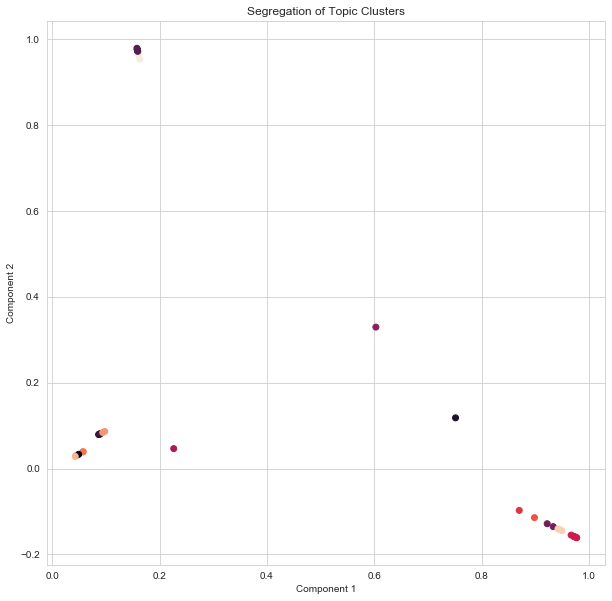

In [21]:
# Plot
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [22]:
# How to get similar documents for any given piece of text
# With the probability of topics for a given document (using predict_topic()),
# compute the euclidean distance with the probability scores of all other documents.
# The most similar documents are the ones with the smallest distance.

In [23]:
from sklearn.metrics.pairwise import euclidean_distances

#nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = neg_reviews, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [24]:
# Get similar documents
mytext = ["Old small room"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = neg_reviews, top_n=1, verbose=True)
#print('\n', docs[0][:500])

Topic KeyWords:  ['room', 'hotel', 'good', 'stay', 'old', 'bad', 'rooms', 'like', 'service', 'coffee', 'want', 'just', 'night', 'breakfast', 'business']
Topic Prob Scores of text:  [[0.1 0.1 0.1 0.8]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.9]]
